#3D Object Detection and Counting (New Method)
---------------------------
By : Juan C. Peña and Eberto Benjumea

**(Pending documentation)**

------------------------------------
# Installing dependences

In [1]:
%%capture
!pip install deeptrack

In [2]:
%%capture
!pip install geopandas

In [3]:
%%capture
from google.colab import drive
drive.mount('/content/drive')

In [4]:
import cv2
import random
import scipy.io
%matplotlib inline
import numpy as np
import deeptrack as dt
import geopandas as gpd
import matplotlib.pyplot as plt
from skimage import img_as_float
from shapely.geometry import Point
from matplotlib.patches import Rectangle
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler

------------------------------------
# Classes creation

In [5]:
class Preprocessor():

  def __init__(self,
               scales=[1, 2, 4]
               ):
    self.scales = scales

  
  def crop(self, image, x, y, wide):
    cropped_image = image[y: y + wide, x: x + wide]

    return cropped_image

  def normalizate(self, image):
    normalized_image = (image - np.quantile(image, 0.01))/ (np.quantile(image, 0.99) - np.quantile(image, 0.01))
    
    return normalized_image

  def resize(self, image, scale):
    resized_image = cv2.resize(image, (0, 0), fx=1/scale, fy=1/scale)

    return resized_image

  def plot_crops(self, list_crops):
    n_crops = len(list_crops)
    print(f'Number of crops: {n_crops}')

    # Plot images
    fig, axs = plt.subplots(1, n_crops, figsize=(10, 10))
    for idx in range(n_crops):
      axs[idx].imshow(list_crops[idx])

    plt.show()

  def generate_pipeline(self, transformations):
    pipeline = None
    for transformation in transformations:
        if pipeline is None:
            pipeline = transformation
        else:
            pipeline = pipeline >> transformation

    return pipeline

  def create_train_data(self, list_images, transformations=[]):
    normalized_images = [self.normalizate(image) for image in list_images]
    training_images = [np.expand_dims(image, axis = -1) for image in normalized_images]

    pipeline = self.generate_pipeline(transformations)
    train_set = dt.Value(lambda: np.array(random.choice(training_images))) >> pipeline
    train_set.plot()

    return train_set

  def load_image(self, image, plot=True):
    input_set = self.normalizate(image)

    if plot:
        plt.imshow(input_set)
    
    return input_set

# --------------------------------------------------------------------
class Trainer():

  def __init__(self,
               filepath,
               model = dt.models.LodeSTAR(input_shape=(None, None, 1)),
               callbacks = [None]
               ):

    self.model = model
    self.filepath = filepath
    self.callbacks = [
        ModelCheckpoint(filepath=self.filepath,
                        save_weights_only=True,
                        monitor='consistency_loss',
                        mode='min',
                        save_best_only=True
                        ),
        EarlyStopping(monitor="total_loss",
                      patience=15,
                      verbose=1,
                      mode="auto",
                      restore_best_weights=True
                      ),
        LearningRateScheduler(lambda epoch, lr: lr if epoch < 10 else lr * np.exp(-0.1))
    ]
  
  def fit(self, train_set, epochs=40, batch_size=8):
    history = self.model.fit(
        train_set,
        epochs = epochs,
        batch_size = batch_size,
        callbacks = self.callbacks)

    return history

  def plot_performance(self, history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
    fig.suptitle('Total loss and consistency loss')

    ax1.plot(history.history['total_loss'])
    ax1.set_title('Total loss')
    ax1.set(xlabel='epoch', ylabel='loss')
    ax1.set_ylim([0, 1.5])

    ax2.plot(history.history['consistency_loss'])
    ax2.set_title('Consitency loss')
    ax2.set(xlabel='epoch', ylabel='loss')
    ax2.set_ylim([0, 1.5])

    plt.show()

# --------------------------------------------------------------------
class Detector():

  def __init__(self,
               downsample,
               alpha = 0.1,
               cutoff = 0.998,
               mode = "quantile",
               model = dt.models.LodeSTAR(input_shape=(None, None, 1)),
               ):
    self.downsample = downsample
    self.alpha = alpha
    self.cutoff = cutoff
    self.mode = mode
    self.model = model

  def detect(self, image, plot=True):
    test_set = image[np.newaxis, :, :, np.newaxis]
    test_image = test_set[:, ::self.downsample, ::self.downsample, :]

    detections = self.model.predict_and_detect(test_image, alpha=self.alpha, beta=1-self.alpha, cutoff=self.cutoff, mode=self.mode)[0]
    detections[:, 1] = detections[:, 1] * self.downsample
    detections[:, 0] = detections[:, 0] * self.downsample

    return detections

  def detect_all(self, image, plot=False):
    detections = self.detect(image)

    if plot:
      plt.imshow(image)
      plt.scatter(detections[:, 1], detections[:, 0], color='r')
      
    return detections

# --------------------------------------------------------------------
class Postprocessor():

  def __init__(self,
               wide=50,
               scales=[1, 2, 4],
               ):
    self.wide = wide
    self.scales = scales
  
  def scale_detections(self, detection, scale):
    scaled_detection = detection * scale

    return scaled_detection.tolist()

  def create_boxes(self, detections):
    list_detections = [Point((x,y)) for (y,x) in detections]
    points = gpd.GeoSeries(list_detections)
    boxes = points.buffer(self.wide, cap_style = 3)
    bounds = np.array([boxes[index].bounds for index in range(len(boxes))])

    return boxes, bounds

  def NMSupression(self, boxes, overlapThresh):
    # Malisiewicz et al. - non_max_suppression_fast
    if len(boxes) == 0:
      return []

    if boxes.dtype.kind == "i":
      boxes = boxes.astype("float")
    pick = []
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
 
    while len(idxs) > 0:
      last = len(idxs) - 1
      i = idxs[last]
      pick.append(i)

      xx1 = np.maximum(x1[i], x1[idxs[:last]])
      yy1 = np.maximum(y1[i], y1[idxs[:last]])
      xx2 = np.minimum(x2[i], x2[idxs[:last]])
      yy2 = np.minimum(y2[i], y2[idxs[:last]])

      w = np.maximum(0, xx2 - xx1 + 1)
      h = np.maximum(0, yy2 - yy1 + 1)

      overlap = (w * h) / area[idxs[:last]]

      idxs = np.delete(idxs, np.concatenate(([last],
        np.where(overlap > overlapThresh)[0])))
      
    return boxes[pick].astype("int")

  def apply_nms(self, image, bounds, figsize = (15,15), overlapThresh=0.3):
    final_detections = self.NMSupression(np.array(bounds),
                                         overlapThresh=overlapThresh)
    self.plot_results(image, final_detections, figsize)

    return final_detections


  def plot_boxes(self, test_image, detections, plot=True):

    if plot:
      fig, ax = plt.subplots(figsize=(15, 15))
      plt.imshow(test_image)

    boxes, bounds = self.create_boxes(detections)

    if plot:
      boxes.boundary.plot(ax=ax, color = 'r')

    return bounds

  def plot_results(self, image, boxes, figsize, color='red', lw=2):
    plt.figure(figsize=figsize)
    plt.imshow(image)

    wide = self.wide * 2
    for i in range(len(boxes)):
      rect = Rectangle((boxes[i][0], boxes[i][1]),wide,wide,
                       edgecolor=color,
                       facecolor='none',
                       lw=lw)
     
      plt.gca().add_patch(rect)

-------------------
# Settings [If training]

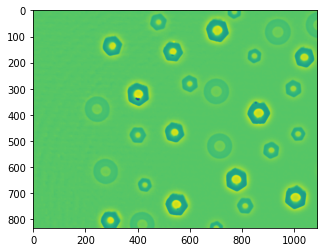

In [6]:
num = 1
train_data = scipy.io.loadmat(f'/content/drive/MyDrive/Investigacion/Data/MATLAB/output/smoothed/reconstruction0{num}.mat')
train_image = train_data['Spz']

size_object = 100 # 100
wide = 20 # size of the training template
downsample = size_object // wide

plt.imshow(train_image)

In [7]:
transformations = (
    #Add:  dt.ElasticTransformation
    dt.Affine(scale=lambda:np.random.uniform(0.8, 1.5, 2), translate=lambda:np.random.uniform(-1.5, 1.5, 2), rotate=lambda: np.random.rand()*np.pi*2),
    dt.AveragePooling(ksize=(downsample, downsample, 1)),
    dt.Add(lambda: np.random.randn() * 0.1),
    dt.Gaussian(sigma=lambda:np.random.uniform(0, 0.01)), # Very sensitive
    dt.Multiply(lambda: np.random.uniform(0.6, 1.2)) # 0.3, 1.6
)

preprocessor = Preprocessor()

# Class 1 - Small nuts

In [8]:
list_crops = []

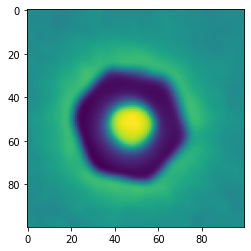

In [9]:
x, y = (380, 615)
crop = preprocessor.crop(train_image, x, y, size_object)
list_crops.append(crop)

plt.imshow(crop)

# Class 2 - Medium nuts

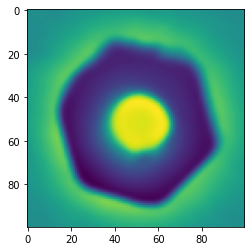

In [10]:
x, y = (490, 415)
crop = preprocessor.crop(train_image, x, y, size_object)
list_crops.append(crop)

plt.imshow(crop)

# Class 3 - Big nuts

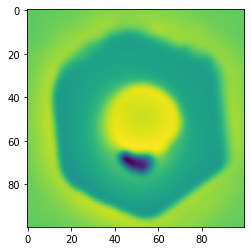

In [11]:
x, y = (350, 270)
crop = preprocessor.crop(train_image, x, y, size_object)
list_crops.append(crop)

plt.imshow(crop)

# Class 4 - Cropped nuts

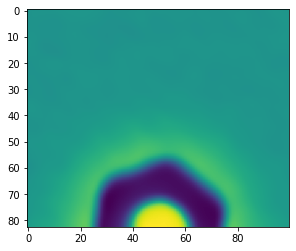

In [120]:
x, y = (650, 750)
crop = preprocessor.crop(train_image, x, y, size_object)
list_crops.append(crop)

plt.imshow(crop)

Number of crops: 3


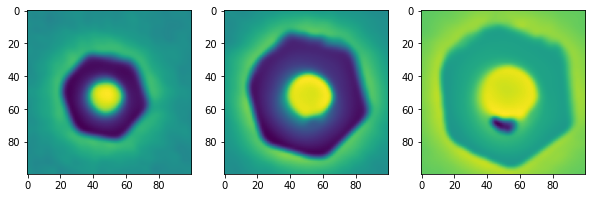

In [12]:
preprocessor.plot_crops(list_crops)

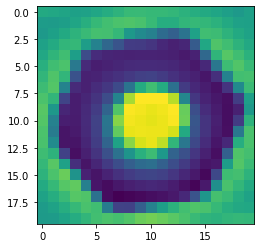

In [14]:
train_set = preprocessor.create_train_data(list_crops, transformations)

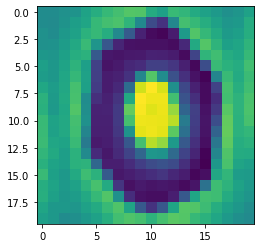

In [18]:
image = train_set.update()()
plt.imshow(image)

In [19]:
filepath = '/content/drive/MyDrive/Investigacion/Model/checkpoints/small_nuts_v4'
trainer = Trainer(filepath)

In [20]:
history = trainer.fit(train_set, epochs=30)

Generating 160 / 160 samples before starting training
Epoch 1/30
160/160 [==============================] - 18s 19ms/step - total_loss: 1.6376 - consistency_loss: 0.5671 - lr: 0.0010
Epoch 2/30
160/160 [==============================] - 7s 44ms/step - total_loss: 0.2692 - consistency_loss: 0.0537 - lr: 0.0010                           
Epoch 3/30
160/160 [==============================] - 9s 56ms/step - total_loss: 0.1408 - consistency_loss: 0.0222 - lr: 0.0010                           
Epoch 4/30
160/160 [==============================] - 7s 45ms/step - total_loss: 0.0979 - consistency_loss: 0.0123 - lr: 0.0010                           
Epoch 5/30
160/160 [==============================] - 9s 57ms/step - total_loss: 0.1010 - consistency_loss: 0.0095 - lr: 0.0010                           
Epoch 6/30
160/160 [==============================] - 8s 52ms/step - total_loss: 0.0980 - consistency_loss: 0.0111 - lr: 0.0010                           
Epoch 7/30
160/160 [======================

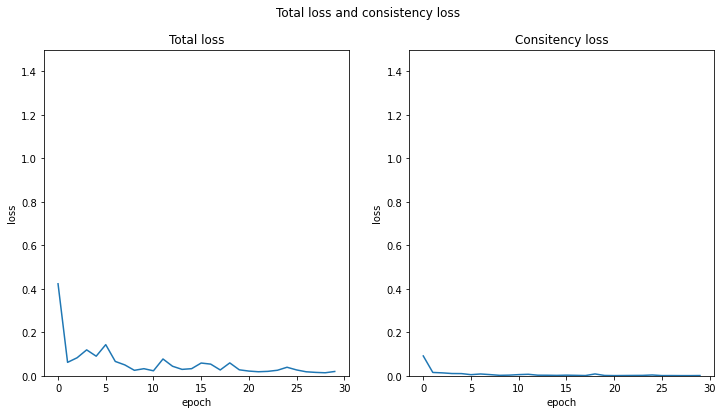

In [21]:
trainer.plot_performance(history)

# Load pre-trained weights

In [ ]:
"""
filepath = '/content/drive/MyDrive/Investigacion/Model/checkpoints/small_nuts'
trainer = Trainer(filepath)
trainer.model = dt.models.LodeSTAR(input_shape=(None, None, 1))
trainer.model.load_weights(filepath)
"""

# Testing

In [22]:
reconstruction_path = f'/content/drive/MyDrive/Investigacion/Data/MATLAB/output/smoothed'
n_images = 8
test_set = [scipy.io.loadmat(f'{reconstruction_path}/reconstruction0{num}.mat')['Spz'] for num in range(1,n_images+1)]
len(test_set)

8

In [23]:
def test(test_data, model, downsample=1, alpha=0.1, cutoff=0.99, mode="quantile", plotPrevious=True):
  preprocessor = Preprocessor()
  test_image = preprocessor.load_image(test_data, plot=plotPrevious)
  detector = Detector(downsample, model=model, alpha=alpha, cutoff=cutoff, mode=mode)
  detections = detector.detect_all(test_image, plot=plotPrevious)
  postprocessor = Postprocessor()
  bounds = postprocessor.plot_boxes(test_image, detections, plot=plotPrevious)
  final_detections = postprocessor.apply_nms(test_image, bounds)

  return final_detections

1/1 [==============================] - 0s 49ms/step


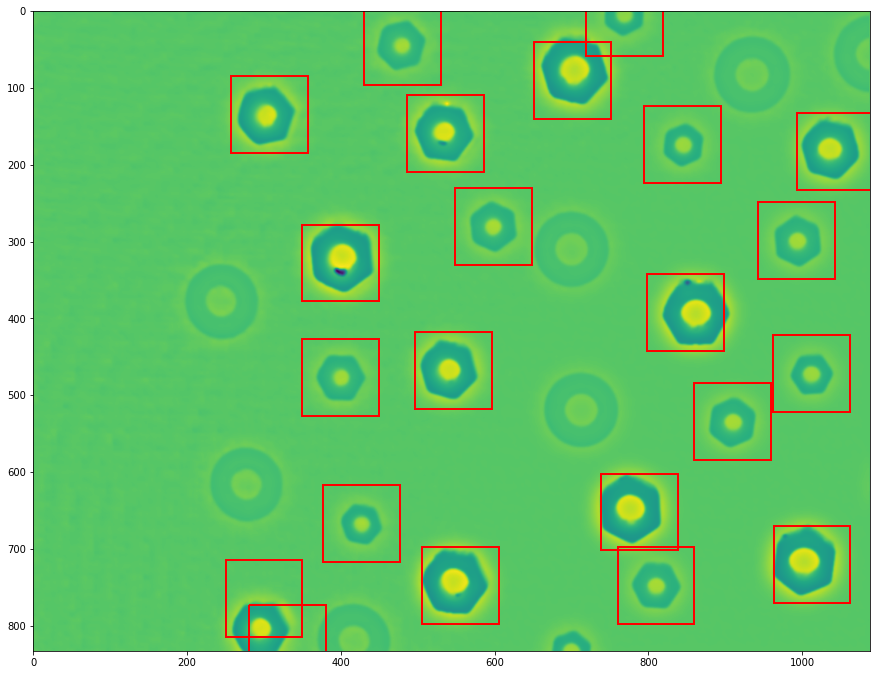

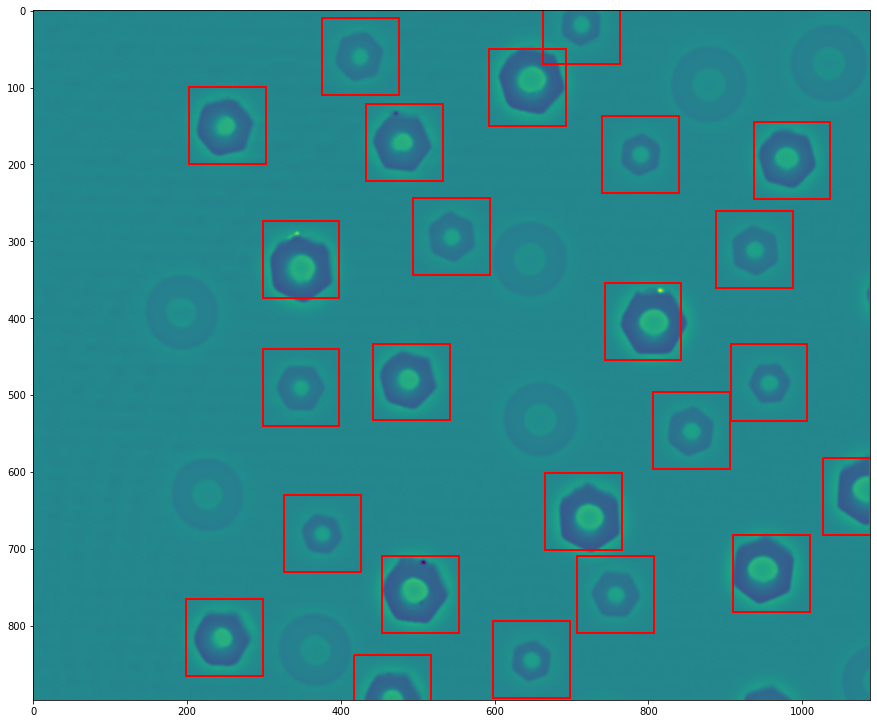

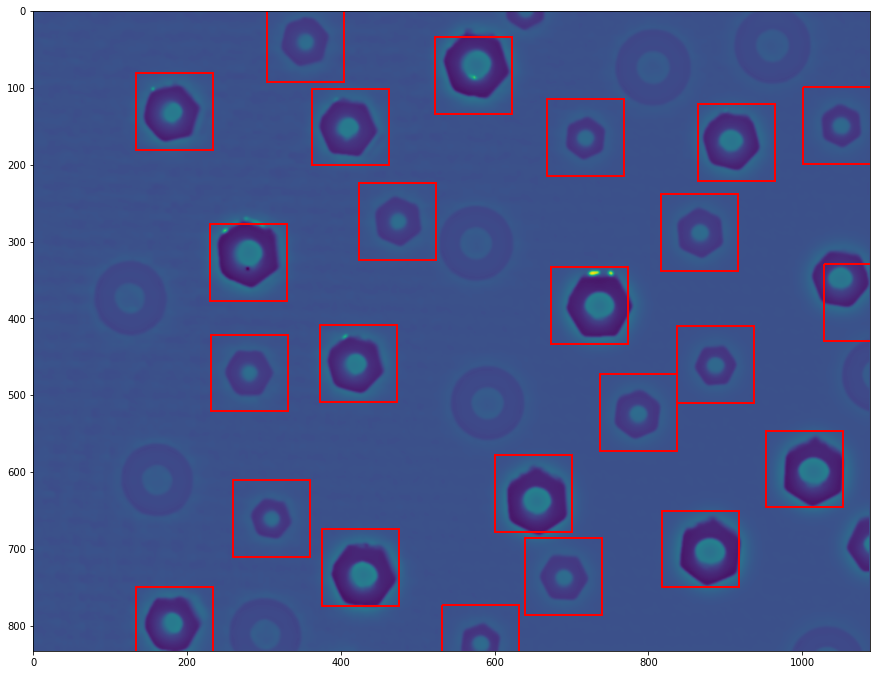

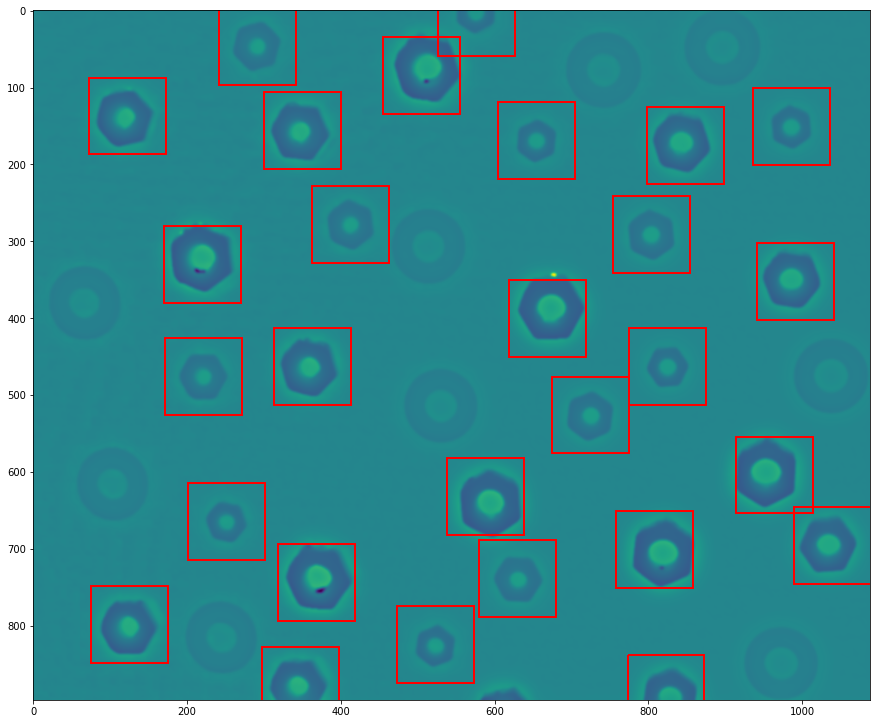

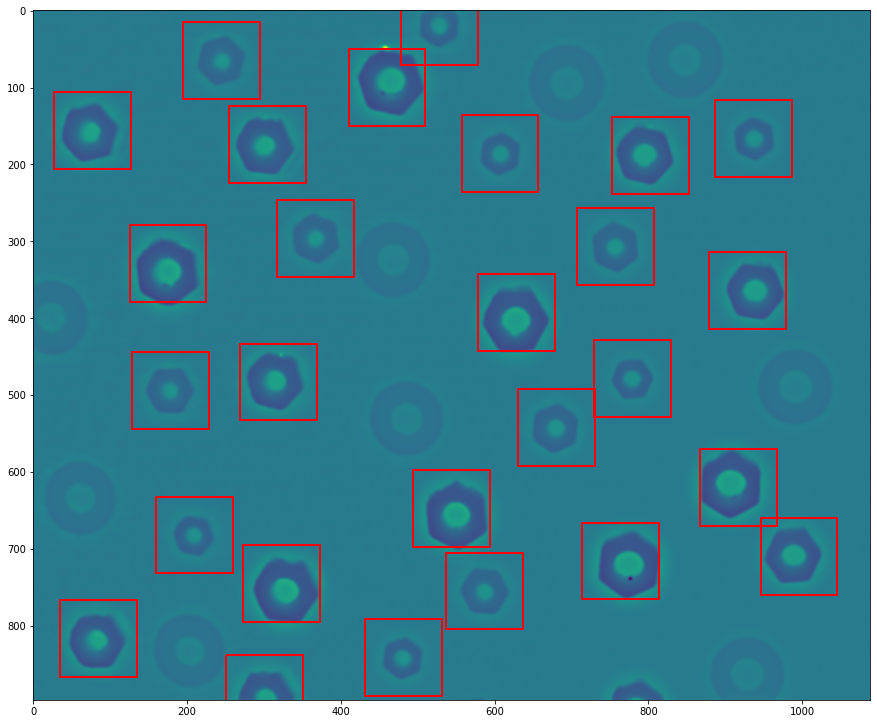

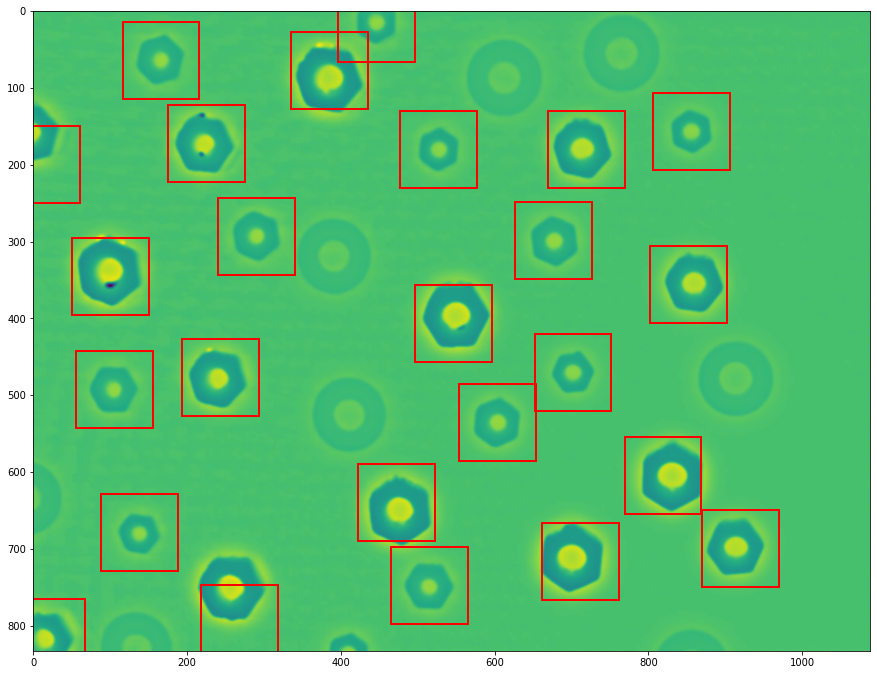

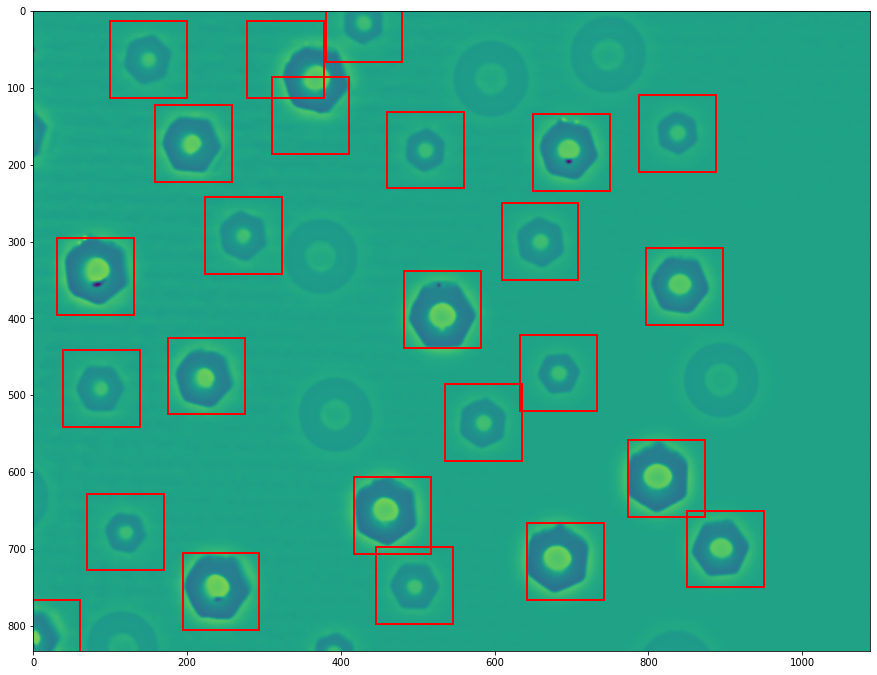

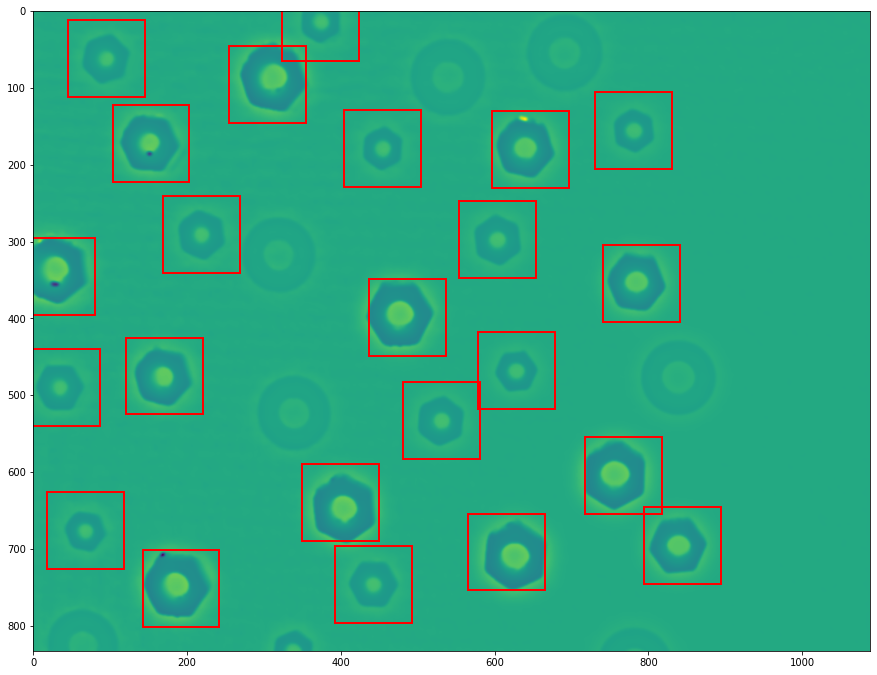

In [27]:
# Detection settings
alpha = 0.1 # 0.1
cutoff = 0.992 # 0.99
mode = "quantile"

for idx in range(len(test_set)):
  final_detections = test(test_set[idx], trainer.model, downsample=2, alpha=alpha, cutoff=cutoff, plotPrevious=False)